---

<div class="alert alert-primary alert-info">

# Monte-Carlo Stochastic Volatility

</div>

---

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(1234)

---

### Cube $\mathbb{R}^3$

- Number of risk factors $\times$ Number of scenarios $\times$ Number of time steps

---

### Correlated paths

 - #### Cholesky Decomposition

In [4]:
def make_uncorrelated_z_cube(num_risk_factors, num_scenarios, num_timesteps):
    return np.random.normal(size=(num_risk_factors, num_scenarios+1, num_timesteps+1))

def make_correlated_z_cube(num_risk_factors, num_scenarios, num_timesteps, cov_matrix):
    L = np.linalg.cholesky(cov_matrix)
    uncorrelated_z = np.random.normal(loc=0.0, scale=1.0, size=(num_risk_factors, (num_scenarios * num_timesteps)))
    return (L @ uncorrelated_z).reshape(num_risk_factors, num_scenarios, num_timesteps)

- #### Numpy Multivariate Normal

In [5]:
def make_correlated_z_cube_multivariate_normal(num_risk_factors, num_scenarios, num_timesteps, cov_matrix):
    return np.random.multivariate_normal(np.zeros(num_risk_factors), cov_matrix, ((num_risk_factors, num_scenarios, num_timesteps)))

---

In [6]:
def generate_cov_matrix_from_scalar_rho(rho, std_dev_vector):
    corr_matrix = np.full((len(std_dev_vector), len(std_dev_vector)), rho)
    np.fill_diagonal(corr_matrix, 1.0)
    sd = np.diag(std_dev_vector)
    return sd @ corr_matrix @ sd

---

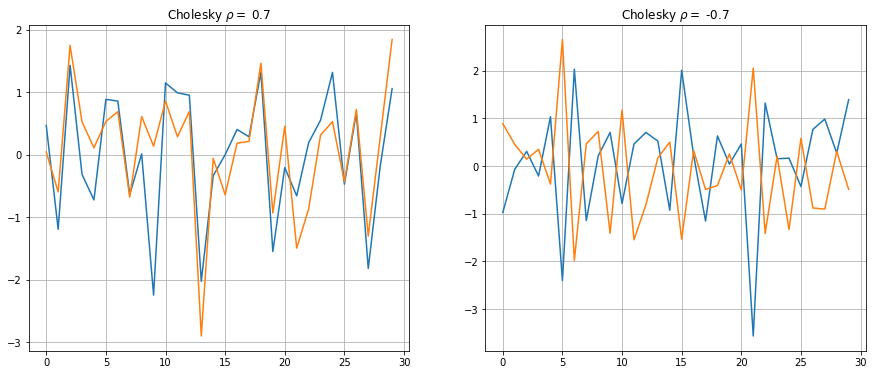

In [7]:
rho = [0.7, -0.7]

cov_matrix = generate_cov_matrix_from_scalar_rho(rho[0], np.ones(2))
correlated_z_paths = make_correlated_z_cube(2, 1, 30, cov_matrix)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 30), correlated_z_paths[0, 0, 0:30])
plt.plot(np.arange(0, 30), correlated_z_paths[1, 0, 0:30])
plt.title(r'Cholesky $\rho=$ {}'.format(rho[0]))
plt.grid()

cov_matrix = generate_cov_matrix_from_scalar_rho(rho[1], np.ones(2))
correlated_z_paths = make_correlated_z_cube(2, 1, 40, cov_matrix)

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 30), correlated_z_paths[0, 0, 0:30])
plt.plot(np.arange(0, 30), correlated_z_paths[1, 0, 0:30])
plt.title(r'Cholesky $\rho=$ {}'.format(rho[1]))
plt.grid();

---

### Heston model

---

$
\begin{align}
dv_t &\sim \mathcal{N}( \kappa (\theta - v_t)dt, \xi^2 v_t dt) \\
dv_t &= \kappa (\theta - v_t)dt + \xi \sqrt{v_t} dW_t^v \\
v_{t+1} &= v_{t} + \kappa (\theta - v_t^{+})\Delta t + \xi \sqrt{v_t^{+}} \Delta W_{t+1}^v
\end{align}
$

---

$
\begin{align}
dS_t &\sim \mathcal{N}( \mu S_t dt, v_t S^2_t dt) \\
dlnS_t &\sim \mathcal{N}( (\mu - \frac{v_{t}}{2})dt, v_{t} dt ) \\
S_{t+1} &= S_t exp((\mu - \frac{1}{2} v_t^{+}) \Delta t + \xi \sqrt{v_t^{+}} \Delta W_{t+1}^S)
\end{align}
$

---

In [8]:
def heston_volatility_full_trunc(cube, mu, v_0, S_0, T, rho, kappa, theta, xi, num_scenarios, num_timesteps):
    
    cube[0, :, 0] = S_0
    cube[1, :, 0] = v_0
    
    dt = T / num_timesteps
    
    for t_i in range(1, num_timesteps):
        
        v_plus = np.maximum(cube[1, :, (t_i - 1)], 0.0)
        
        cube[1, :, t_i] = cube[1, :, t_i - 1] + kappa * dt * (theta - v_plus) + \
                                                xi * np.sqrt(v_plus * dt) * cube[1, :, t_i]
        
        cube[0, :, t_i] = cube[0, :, t_i - 1] * np.exp((mu - 0.5 * v_plus) * dt + \
                                                np.sqrt(v_plus * dt) * cube[0, :, t_i])

    return cube[0]

#### Option parameters: [Broadie, M., Kaya, O]

In [9]:
S_0 = 100.0
K = 100.0
v_0 = 0.010201
kappa = 6.21
theta = 0.019
xi = 0.61
rho = -0.7
mu = 0.0319
T = 1.0

- #### Projection $\ldots$

In [10]:
num_risk_factors = 2
num_scenarios = 100000
num_timesteps = 1000

cov_matrix = generate_cov_matrix_from_scalar_rho(rho, np.ones(num_risk_factors))
cube = make_correlated_z_cube(num_risk_factors, num_scenarios, num_timesteps, cov_matrix)

projection = heston_volatility_full_trunc(cube, mu, v_0, S_0, T, rho, kappa, theta, xi, num_scenarios, num_timesteps)
call_payoffs = np.maximum((projection[:, num_timesteps - 1] - K), np.zeros(num_scenarios))

- #### Discounting $\ldots$

In [11]:
print('Simulated option price: {}'.format(np.mean(call_payoffs) * np.exp(-mu * T)))
print('True option price = 6.8061. Broadie, M., Kaya, O')

Simulated option price: 6.812775473364275
True option price = 6.8061. Broadie, M., Kaya, O


---

- Broadie, M., Kaya, O. Exact Simulation of Stochastic Volatility and other Affine Jump Diffusion Processes